In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [3]:
graph_builder = StateGraph(State)

In [4]:
import os
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
os.environ["GROQ_API_KEY"]= GROQ_API_KEY

In [5]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.1-8b-instant")
llm.invoke("hi").content

d:\LangGraph-End-to-End-Course\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'How can I assist you today?'

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [7]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")

In [8]:
graph_builder.add_edge("chatbot", END)

In [9]:
graph = graph_builder.compile()

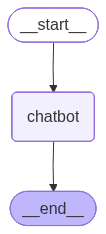

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [12]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: How can I help you today?
Assistant: Goodbye.
Assistant: The letter "q" is a unique and interesting letter in the English alphabet. Here are a few interesting facts about "q":

1. **The only letter in English that doesn't have a single vowel sound when it appears by itself in a word.** When "q" appears with a following "u", it forms a distinct sound, often described as a "kuh" sound.

2. **The letter "q" is often paired with the letter "u".** This is because in Old French, the language from which English adopted the letter "q", the letter "q" was often used in combination with the letter "u".

3. **The letter "q" has been used in many languages, including ancient languages such as Phoenician and Arabic.** In these languages, the letter "q" had different sounds and uses.

4. **The letter "q" is an important letter in many words related to technology, such as "quad-core", "query", and "quantum".

Overall, the letter "q" is a fascinating letter that has a rich history and is us

In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

C:\Users\Suresh Beekhani\AppData\Local\Temp\ipykernel_21912\3979812345.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


[{'title': 'What is LangGraph? - IBM',
  'url': 'https://www.ibm.com/think/topics/langgraph',
  'content': 'Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. Nodes can be thought of as “actors” that interact with each other in a specific way. For example,to add nodes for tool calling, one can use the ToolNode. Another example, the next node, refers to the node that will be executed following the current one.\n\nEdges: Edges are a function within Python that determines which node to execute next based on the current state. Edges can be conditional branches or fixed transitions.\n\n#### Tools\n\nRAG: Retrieval-augmented generation (RAG) combines the power of LLMs with contextual information from external sources by retrieving relevant documents, which are then used as input for answer generation.',
  'score': 0.8886914},
 {'title': 'Understanding Core Concepts of LangGraph (Deep Dive)',
  'url': 'https://dev.to/raunaklallala/understanding-core-co

In [14]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [15]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [16]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

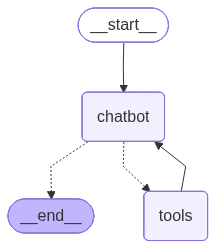

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"title": "Why Traditional RAG Fails \u2014 and How Corrective ...", "url": "https://www.linkedin.com/pulse/why-traditional-rag-fails-how-corrective-fixes-data-scientist--vzjuf", "content": "## Sign in to view more content\n\nCreate your free account or sign in to continue your search\n\nNew to LinkedIn? Join now\n\nBy clicking Continue to join or sign in, you agree to LinkedIn\u2019s User Agreement, Privacy Policy, and Cookie Policy.\n\nLinkedIn is better on the app\n\nDon\u2019t have the app? Get it in the Microsoft Store.\n\n Open the app\n\n# Why Traditional RAG Fails \u2014 and How Corrective RAG Fixes It\n\n Report this article\n\nSuresh Beekhani ( Data Scientist ) \n\n### Suresh Beekhani ( Data Scientist )\n\nPublished Jan 25, 2026\n\n+ Follow\n\nRetrieval-Augmented Generation (RAG) has become a foundational pattern for building AI systems that rely on external knowledge. Yet, as RAG systems move from demos to real-world production, many teams are discove

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [20]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [21]:
graph = graph_builder.compile(checkpointer=memory)

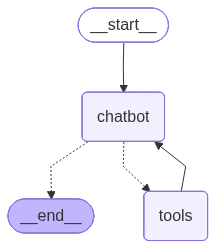

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
config = {"configurable": {"thread_id": "1"}}

In [24]:
user_input = "Hi there! My name is name suresh."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is name suresh.
================================== Ai Message ==================================

Hello name suresh, it's nice to meet you. Is there something I can help you with today?


In [25]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'll try to remember it for our conversation. You are name suresh. If you want to remind me again or need help with something, feel free to say so.

(function=tavily_search_results_json>{"query": "remembering names in conversations"}}


In [26]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Unfortunately, I'm a large language model, I don't have the ability to remember individual users or their preferences. Each time you interact with me, it's a new conversation and I don't retain any information from previous conversations. So, I won't be able to recall your name this time either.


In [27]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (02g2nchbh)
 Call ID: 02g2nchbh
  Args:
    query: name recall
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "5 Science-Backed Strategies for Remembering Names", "url": "https://www.nasarizona.com/blog/5-science-backed-strategies-for-remembering-names", "content": "This challenge isn't necessarily a sign of poor memory function—it's a specific cognitive task that many people find challenging regardless of age or overall cognitive health. Why is name recall particularly difficult? Our brains process names differently than other information. Names are typically arbitrary labels without inherent meaning, making them harder to encode in memory than descriptive information. Additionally, social